In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Clustering

In [4]:
features = pd.read_csv('item_features.csv')

In [5]:
n_pca_comp = 16
number_of_clusters = 4

In [6]:
features_ones = features.copy()
features_ones["feature_value_id"]=1
features_ones = features_ones.dropna()
features_ones = features_ones.pivot_table(values='feature_value_id', index='item_id', columns='feature_category_id', aggfunc='first')
features_ones = features_ones.replace(np.nan, 0)
features_matrix = features.pivot_table(values='feature_value_id', index='item_id', columns='feature_category_id', aggfunc='first')

In [7]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features_scaled=ss.fit_transform(features_ones)
features_scaled= pd.DataFrame(features_scaled)

In [8]:
cluster_assign = pd.read_csv('cluster_assign.csv')
cluster_assign = cluster_assign[['item_id2', 'Cluster_pred']]
cluster_assign

,item_id2,Cluster_pred
0,2,0
1,3,1
2,4,1
3,7,3
4,8,1
...,...,...
23686,28139,1
23687,28140,2
23688,28141,1
23689,28142,3


# Dataset train_sessions

- Primer producto visto
- Fecha de visualización del primer producto
- Último producto visto
- Fecha de visualización del último producto
- Tiempo total de sesión (s)
- Promedio de tiempo en artículos
- Momento del día de inicio de sesión
- Una cadena de productos vistos en orden

In [9]:
df_sessions = pd.read_csv('train_sessions.csv')

In [10]:
df_sessions.head()

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211


In [11]:
session_sorted = df_sessions.sort_values(by=['date'])

# First date of session
begin_df = session_sorted.groupby('session_id')['date'].first().rename('start_date')

# First product of session
first_prod = session_sorted.groupby('session_id')['item_id'].first().rename('first_prod')

# Number of products seen in the session
prod_count = session_sorted.groupby('session_id')['item_id'].count().rename('prod_count')

# Last date of the session
end_df = session_sorted.groupby('session_id')['date'].last().rename('end_date')

# Last product of the session
last_prod = session_sorted.groupby('session_id')['item_id'].first().rename('last_prod')

# most common category in these session
join_cat = session_sorted.merge(features, on='item_id', how='left').sort_values(by=['feature_category_id'])
common_cat = join_cat.groupby(['session_id'])['feature_category_id'].value_counts().rename('most_common_cat')
common_cat_df = common_cat.to_frame(name = None).reset_index()
common_cat = common_cat_df.groupby(['session_id'])['feature_category_id'].first().rename('most_common_cat')

# counting number of unique categories for session
count_num_unique_cat = common_cat_df.groupby(['session_id'])['feature_category_id'].count().rename('count_num_unique_cat')


# Concat the datasets
times_df = pd.concat([begin_df, end_df, first_prod, last_prod, 
                      prod_count, common_cat, count_num_unique_cat
                     ],axis=1)

# Proper time format
times_df['start_date'] = pd.to_datetime(times_df['start_date'])
times_df['end_date'] = pd.to_datetime(times_df['end_date'])

# Calculatind the date difference
times_df['time_diff'] = (times_df.end_date-times_df.start_date).astype('timedelta64[s]')
times_df['time_diff'] = times_df['time_diff'].astype(int)

# Calculating the time per product
times_df['time_per_prod'] = (times_df['time_diff']/times_df['prod_count']).astype(int)

# Adding the time of the day
mask=(times_df.start_date.dt.hour>=0) & (times_df.start_date.dt.hour<7)
times_df.loc[mask,'time_first_prod'] = 'madrugada'
mask=(times_df.start_date.dt.hour>=7) & (times_df.start_date.dt.hour<12)
times_df.loc[mask,'time_first_prod'] = 'día'
mask=(times_df.start_date.dt.hour>=12) & (times_df.start_date.dt.hour<18)
times_df.loc[mask,'time_first_prod'] = 'tarde'
mask=(times_df.start_date.dt.hour>=18) & (times_df.start_date.dt.hour<24)
times_df.loc[mask,'time_first_prod'] = 'noche'


In [12]:
sessions=times_df
sessions

,start_date,end_date,first_prod,last_prod,prod_count,most_common_cat,count_num_unique_cat,time_diff,time_per_prod,time_first_prod
session_id,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,2,18,312,156,noche
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,4,20,0,0,noche
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,1,25,163,54,noche
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,4,28,1082,63,tarde
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,30,43,3703,411,tarde
...,...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,4,18,533,88,día
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,4,46,3458,314,día
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,3,25,0,0,noche


# Purchases

In [13]:
purchases = pd.read_csv('train_purchases.csv').set_index('session_id')
purchases['date']=pd.to_datetime(purchases['date'])
purchases.rename(columns={'item_id':'item_purch','date':'purch_date'}, inplace=True)
purchases.head()

,item_purch,purch_date
session_id,,
3,15085,2020-12-18 21:26:47.986
13,18626,2020-03-13 19:36:15.507
18,24911,2020-08-26 19:20:32.049
19,12534,2020-11-02 17:16:45.920
24,13226,2020-02-26 18:27:44.114


In [14]:
purchases.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 3 to 4440001
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   item_purch  1000000 non-null  int64         
 1   purch_date  1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.9 MB


# Features
- Tabla con sesiones y veces que se ha visto cada clúster

In [15]:
item_clust = cluster_assign[['item_id2', 'Cluster_pred']].set_index('item_id2')
item_clust["cluster"] = item_clust.apply(lambda x: "group_" + str(x.Cluster_pred), axis=1)
item_clust = item_clust[["cluster"]]
item_clust

,cluster
item_id2,
2,group_0
3,group_1
4,group_1
7,group_3
8,group_1
...,...
28139,group_1
28140,group_2
28141,group_1


In [16]:
df_sess_clust=df_sessions.merge(item_clust, left_on='item_id', right_index=True)
df_sess_clust

,session_id,item_id,date,cluster
0,3,9655,2020-12-18 21:25:00.373,group_2
1,3,9655,2020-12-18 21:19:48.093,group_2
103605,97085,9655,2020-12-27 20:22:13.011,group_2
162423,152155,9655,2020-11-19 16:26:18.468,group_2
225780,210806,9655,2021-01-02 05:37:37.183,group_2
...,...,...,...,...
4737630,4434058,3416,2020-11-14 23:33:46.655,group_1
4737631,4434058,15964,2020-11-14 23:33:58.652,group_1
4739963,4436170,27863,2020-07-20 06:36:30.611,group_3
4741053,4437232,7735,2020-01-02 20:07:06.367,group_1


In [17]:
df_clust_count = df_sess_clust.groupby(['session_id', 'cluster'])['session_id'].aggregate('count').unstack().fillna(0)


In [18]:
df_clust_count

cluster,group_0,group_1,group_2,group_3
session_id,,,,
3,0.0,0.0,2.0,0.0
13,1.0,0.0,0.0,0.0
18,0.0,3.0,0.0,0.0
19,0.0,17.0,0.0,0.0
24,5.0,0.0,1.0,3.0
...,...,...,...,...
4439986,6.0,0.0,0.0,0.0
4439990,2.0,8.0,1.0,0.0
4439994,0.0,1.0,0.0,0.0


# Combinar los datasets

In [19]:
df=pd.concat([sessions, purchases, df_clust_count], axis=1)
df

,start_date,end_date,first_prod,last_prod,prod_count,most_common_cat,count_num_unique_cat,time_diff,time_per_prod,time_first_prod,item_purch,purch_date,group_0,group_1,group_2,group_3
session_id,,,,,,,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,2,18,312,156,noche,15085,2020-12-18 21:26:47.986,0.0,0.0,2.0,0.0
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,4,20,0,0,noche,18626,2020-03-13 19:36:15.507,1.0,0.0,0.0,0.0
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,1,25,163,54,noche,24911,2020-08-26 19:20:32.049,0.0,3.0,0.0,0.0
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,4,28,1082,63,tarde,12534,2020-11-02 17:16:45.920,0.0,17.0,0.0,0.0
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,30,43,3703,411,tarde,13226,2020-02-26 18:27:44.114,5.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,4,18,533,88,día,2915,2021-05-13 11:56:37.464,6.0,0.0,0.0,0.0
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,4,46,3458,314,día,8786,2020-08-22 14:28:22.382,2.0,8.0,1.0,0.0
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,3,25,0,0,noche,21630,2020-11-27 20:10:28.961,0.0,1.0,0.0,0.0


In [20]:
for i in range(4):
    df["perc_" + str(i)] = df.apply(lambda x: x["group_" + str(i)] / x.prod_count, axis=1)

df

,start_date,end_date,first_prod,last_prod,prod_count,most_common_cat,count_num_unique_cat,time_diff,time_per_prod,time_first_prod,item_purch,purch_date,group_0,group_1,group_2,group_3,perc_0,perc_1,perc_2,perc_3
session_id,,,,,,,,,,,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,2,18,312,156,noche,15085,2020-12-18 21:26:47.986,0.0,0.0,2.0,0.0,0.000000,0.000000,1.000000,0.000000
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,4,20,0,0,noche,18626,2020-03-13 19:36:15.507,1.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,1,25,163,54,noche,24911,2020-08-26 19:20:32.049,0.0,3.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,4,28,1082,63,tarde,12534,2020-11-02 17:16:45.920,0.0,17.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,30,43,3703,411,tarde,13226,2020-02-26 18:27:44.114,5.0,0.0,1.0,3.0,0.555556,0.000000,0.111111,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,4,18,533,88,día,2915,2021-05-13 11:56:37.464,6.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,4,46,3458,314,día,8786,2020-08-22 14:28:22.382,2.0,8.0,1.0,0.0,0.181818,0.727273,0.090909,0.000000
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,3,25,0,0,noche,21630,2020-11-27 20:10:28.961,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000


In [21]:
df_clusters = df[["group_0", "group_1", "group_2", "group_3"]]
df = df.drop(["group_0", "group_1", "group_2", "group_3"], axis = 1)
df

,start_date,end_date,first_prod,last_prod,prod_count,most_common_cat,count_num_unique_cat,time_diff,time_per_prod,time_first_prod,item_purch,purch_date,perc_0,perc_1,perc_2,perc_3
session_id,,,,,,,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,2,18,312,156,noche,15085,2020-12-18 21:26:47.986,0.000000,0.000000,1.000000,0.000000
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,4,20,0,0,noche,18626,2020-03-13 19:36:15.507,1.000000,0.000000,0.000000,0.000000
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,1,25,163,54,noche,24911,2020-08-26 19:20:32.049,0.000000,1.000000,0.000000,0.000000
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,4,28,1082,63,tarde,12534,2020-11-02 17:16:45.920,0.000000,1.000000,0.000000,0.000000
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,30,43,3703,411,tarde,13226,2020-02-26 18:27:44.114,0.555556,0.000000,0.111111,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439986,2021-05-13 11:46:56.606,2021-05-13 11:55:50.151,23502,23502,6,4,18,533,88,día,2915,2021-05-13 11:56:37.464,1.000000,0.000000,0.000000,0.000000
4439990,2020-08-22 11:38:48.785,2020-08-22 12:36:27.326,22093,22093,11,4,46,3458,314,día,8786,2020-08-22 14:28:22.382,0.181818,0.727273,0.090909,0.000000
4439994,2020-11-27 20:08:37.262,2020-11-27 20:08:37.262,25357,25357,1,3,25,0,0,noche,21630,2020-11-27 20:10:28.961,0.000000,1.000000,0.000000,0.000000


In [22]:
df = df[df.index<1200000]

df

,start_date,end_date,first_prod,last_prod,prod_count,most_common_cat,count_num_unique_cat,time_diff,time_per_prod,time_first_prod,item_purch,purch_date,perc_0,perc_1,perc_2,perc_3
session_id,,,,,,,,,,,,,,,,
3,2020-12-18 21:19:48.093,2020-12-18 21:25:00.373,9655,9655,2,2,18,312,156,noche,15085,2020-12-18 21:26:47.986,0.000000,0.0,1.000000,0.000000
13,2020-03-13 19:35:27.136,2020-03-13 19:35:27.136,15654,15654,1,4,20,0,0,noche,18626,2020-03-13 19:36:15.507,1.000000,0.0,0.000000,0.000000
18,2020-08-26 19:15:47.232,2020-08-26 19:18:30.833,4026,4026,3,1,25,163,54,noche,24911,2020-08-26 19:20:32.049,0.000000,1.0,0.000000,0.000000
19,2020-11-02 16:30:36.378,2020-11-02 16:48:39.343,19896,19896,17,4,28,1082,63,tarde,12534,2020-11-02 17:16:45.920,0.000000,1.0,0.000000,0.000000
24,2020-02-26 17:22:48.903,2020-02-26 18:24:32.770,2927,2927,9,30,43,3703,411,tarde,13226,2020-02-26 18:27:44.114,0.555556,0.0,0.111111,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199971,2020-10-03 08:49:02.028,2020-10-03 08:59:31.793,121,121,11,4,25,629,57,día,23166,2020-10-03 09:02:31.164,0.000000,1.0,0.000000,0.000000
1199975,2020-10-11 14:54:02.670,2020-10-11 14:56:42.980,8060,8060,3,4,19,160,53,tarde,4028,2020-10-11 14:57:27.151,1.000000,0.0,0.000000,0.000000
1199982,2021-02-03 09:46:50.941,2021-02-03 09:46:50.941,10413,10413,1,3,26,0,0,día,15801,2021-02-03 09:47:03.332,0.000000,1.0,0.000000,0.000000


In [23]:
df.to_csv('dataset_merge.csv')

<AxesSubplot:>

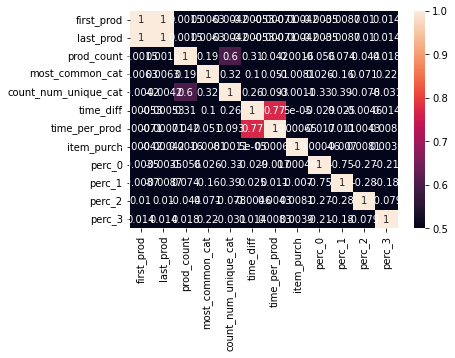

In [24]:
sns.heatmap(df.corr(), annot=True, vmin=0.5) # new 

In [25]:
print(number_of_clusters)

4


### How many type of items are seen in each session?

In [26]:
df_clusts = df_clusters
df_clusts = df_clusts.replace(0, np.nan)
df_clusts["distinct"] = df_clusts.count(1)
#df_clusts.head()
item_counts = df_clusts["distinct"].value_counts()
print(item_counts)

1    676111
2    248581
3     66533
4      8775
Name: distinct, dtype: int64


In [27]:
df_clusts = df_clusters
df_clusts = df_clusts.replace(0, np.nan)
df_clusts["sum"] = df_clusts.sum(axis=1)
df_clusts = df_clusts[df_clusts["sum"] > 4.0]
df_clusts["distinct"] = df_clusters.count(1)
df_clusts.head()
item_counts = df_clusts["distinct"].value_counts()
print(item_counts)

4    319722
Name: distinct, dtype: int64


## Divide into train - validation

There are several ways to divide your training data. Sometimes it is important to create a stratified sampling.

In [28]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
len(train_set),len(test_set)

(215638, 53910)

## Prepare the data for Machine Learning algorithms

In [29]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
train_set_1hot = cat_encoder.fit_transform(train_set.fillna('Unknown'))

In [30]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [31]:
train_set_num = train_set[["prod_count", "time_diff", "time_per_prod", "perc_0", "perc_1", "perc_2", "perc_3"]]

In [32]:
imputer.fit(train_set_num)
imputer.statistics_

array([  3. , 106. ,  30. ,   0.2,   0.4,   0. ,   0. ])

In [33]:
train_set_num.median().values

array([  3. , 106. ,  30. ,   0.2,   0.4,   0. ,   0. ])

In [34]:
X = imputer.transform(train_set_num)

In [35]:
train_set_tr = pd.DataFrame(X, columns=train_set_num.columns,
                          index=train_set.index)

In [36]:
imputer.strategy

'median'

In [37]:
train_set_tr.head()

,prod_count,time_diff,time_per_prod,perc_0,perc_1,perc_2,perc_3
session_id,,,,,,,
103270,7.0,292.0,41.0,0.142857,0.857143,0.0,0.0
822218,1.0,0.0,0.0,0.000000,1.000000,0.0,0.0
600200,4.0,172.0,43.0,1.000000,0.000000,0.0,0.0
342650,4.0,106.0,26.0,1.000000,0.000000,0.0,0.0
607637,1.0,0.0,0.0,0.000000,1.000000,0.0,0.0


### Categorical data

Now let's preprocess the categorical input time_first_prod:

In [38]:
train_set_cat = train_set[["first_prod", "last_prod", "time_first_prod", "most_common_cat", "count_num_unique_cat"]]
# There is missing values in this category, we will create a new cateogry for those.
train_set_cat.fillna('Unknown').head(10)

,first_prod,last_prod,time_first_prod,most_common_cat,count_num_unique_cat
session_id,,,,,
103270,2282,2282,noche,4,31
822218,12117,12117,noche,3,25
600200,21557,21557,día,4,20
342650,10383,10383,día,30,19
607637,3583,3583,tarde,3,25
159501,23733,23733,tarde,4,18
738004,13131,13131,noche,3,25
1111694,10795,10795,tarde,30,19
811221,18385,18385,tarde,4,21


In [39]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
train_set_cat_encoded = ordinal_encoder.fit_transform(train_set_cat.fillna('Unknown'))
train_set_cat_encoded[:10]

array([[1.3800e+03, 1.3800e+03, 2.0000e+00, 3.0000e+00, 2.8000e+01],
       [7.4530e+03, 7.4530e+03, 2.0000e+00, 2.0000e+00, 2.2000e+01],
       [1.3236e+04, 1.3236e+04, 0.0000e+00, 3.0000e+00, 1.7000e+01],
       [6.4000e+03, 6.4000e+03, 0.0000e+00, 1.1000e+01, 1.6000e+01],
       [2.1740e+03, 2.1740e+03, 3.0000e+00, 2.0000e+00, 2.2000e+01],
       [1.4546e+04, 1.4546e+04, 3.0000e+00, 3.0000e+00, 1.5000e+01],
       [8.0730e+03, 8.0730e+03, 2.0000e+00, 2.0000e+00, 2.2000e+01],
       [6.6610e+03, 6.6610e+03, 3.0000e+00, 1.1000e+01, 1.6000e+01],
       [1.1301e+04, 1.1301e+04, 3.0000e+00, 3.0000e+00, 1.8000e+01],
       [2.2600e+03, 2.2600e+03, 3.0000e+00, 3.0000e+00, 2.6000e+01]])

In [40]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
train_set_cat_1hot = cat_encoder.fit_transform(train_set_cat.fillna('Unknown'))
train_set_cat_1hot

<215638x34540 sparse matrix of type '<class 'numpy.float64'>'
	with 1078190 stored elements in Compressed Sparse Row format>

In [41]:
train_set_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

train_set_num_tr = num_pipeline.fit_transform(train_set_num)

In [43]:
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

In [44]:
from sklearn.compose import ColumnTransformer

num_attribs1 = train_set_num.select_dtypes(include="object").columns
cat_attribs = train_set_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
    ])

train_set_prepared = full_pipeline.fit_transform(train_set)

train_set_prepared

<215638x4 sparse matrix of type '<class 'numpy.float64'>'
	with 215638 stored elements in Compressed Sparse Row format>

## RandomForestRegressor

In [45]:
## Let's try another model: Random Forest
from sklearn.ensemble import RandomForestClassifier

forest_class = RandomForestClassifier(n_estimators=20, random_state=42)
forest_class.fit(train_set_prepared, train_set[["item_purch"]].to_numpy().ravel())

RandomForestClassifier(n_estimators=20, random_state=42)

In [46]:
test_set_num = test_set[["prod_count", "time_diff", "time_per_prod", "perc_0", "perc_1", "perc_2", "perc_3"]]
test_set_cat = test_set[["first_prod", "last_prod", "time_first_prod", "most_common_cat", "count_num_unique_cat"]]

num_attribs2 = test_set_num.select_dtypes(include="object").columns
cat_attribs2 = test_set_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs2),
        ("cat", cat_pipeline, cat_attribs2),
    ])

test_set_prepared = full_pipeline.fit_transform(test_set)

forest_class.score(test_set_prepared, test_set[["item_purch"]].to_numpy().ravel())

predictions = forest_class.predict_proba(test_set_prepared)

pred_df_test = pd.DataFrame(predictions)
pred_df_test.columns = forest_class.classes_

pred_df_test["session_id"] = test_set.index
pred_df_test = pred_df_test.merge(df[["item_purch"]], how='inner', on='session_id')
pred_df_test = pred_df_test[["session_id", "item_purch"] + list(pred_df_test.columns[:-2])]
pred_df_test

,session_id,item_purch,3,4,8,9,11,13,16,18,...,28131,28132,28133,28135,28137,28138,28139,28140,28141,28143
0,628488,15853,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
1,602830,5274,0.000021,0.000027,0.000022,0.000009,0.000015,0.000028,0.000024,0.000010,...,0.000038,0.00007,0.000496,0.000043,0.000074,0.000048,0.000094,0.000041,0.000010,0.0
2,436536,19806,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
3,567598,25062,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
4,281797,24971,0.000021,0.000027,0.000022,0.000009,0.000015,0.000028,0.000024,0.000010,...,0.000038,0.00007,0.000496,0.000043,0.000074,0.000048,0.000094,0.000041,0.000010,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53905,727566,11825,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
53906,839859,6229,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
53907,565093,18686,0.000021,0.000027,0.000022,0.000009,0.000015,0.000028,0.000024,0.000010,...,0.000038,0.00007,0.000496,0.000043,0.000074,0.000048,0.000094,0.000041,0.000010,0.0
53908,425636,10997,0.000017,0.000088,0.000009,0.000000,0.000000,0.000014,0.000000,0.000023,...,0.000044,0.00011,0.000638,0.000083,0.000112,0.000027,0.000101,0.000112,0.000022,0.0


In [47]:
train_set

,start_date,end_date,first_prod,last_prod,prod_count,most_common_cat,count_num_unique_cat,time_diff,time_per_prod,time_first_prod,item_purch,purch_date,perc_0,perc_1,perc_2,perc_3
session_id,,,,,,,,,,,,,,,,
103270,2021-01-05 19:08:43.189,2021-01-05 19:13:35.680,2282,2282,7,4,31,292,41,noche,7011,2021-01-05 19:14:22.897,0.142857,0.857143,0.0,0.0
822218,2020-06-16 19:25:59.694,2020-06-16 19:25:59.694,12117,12117,1,3,25,0,0,noche,12409,2020-06-16 19:29:54.153,0.000000,1.000000,0.0,0.0
600200,2021-05-06 11:06:30.564,2021-05-06 11:09:23.523,21557,21557,4,4,20,172,43,día,15551,2021-05-06 12:48:58.230,1.000000,0.000000,0.0,0.0
342650,2020-02-19 09:16:24.194,2020-02-19 09:18:11.056,10383,10383,4,30,19,106,26,día,2077,2020-02-19 09:19:30.306,1.000000,0.000000,0.0,0.0
607637,2021-02-21 12:41:44.925,2021-02-21 12:41:44.925,3583,3583,1,3,25,0,0,tarde,27579,2021-02-21 12:41:52.945,0.000000,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534742,2020-01-30 09:04:37.840,2020-01-30 09:25:32.165,5769,5769,10,7,34,1254,125,día,20679,2020-01-30 09:31:47.630,0.200000,0.300000,0.0,0.5
1153791,2020-09-01 13:06:47.758,2020-09-01 13:08:38.999,678,678,5,47,30,111,22,tarde,2555,2020-09-01 13:09:27.196,0.600000,0.000000,0.4,0.0
588863,2020-08-02 02:48:47.138,2020-08-02 02:48:47.138,14184,14184,1,3,24,0,0,madrugada,18516,2020-08-02 02:49:24.961,0.000000,1.000000,0.0,0.0


In [48]:
pred_df_test

,session_id,item_purch,3,4,8,9,11,13,16,18,...,28131,28132,28133,28135,28137,28138,28139,28140,28141,28143
0,628488,15853,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
1,602830,5274,0.000021,0.000027,0.000022,0.000009,0.000015,0.000028,0.000024,0.000010,...,0.000038,0.00007,0.000496,0.000043,0.000074,0.000048,0.000094,0.000041,0.000010,0.0
2,436536,19806,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
3,567598,25062,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
4,281797,24971,0.000021,0.000027,0.000022,0.000009,0.000015,0.000028,0.000024,0.000010,...,0.000038,0.00007,0.000496,0.000043,0.000074,0.000048,0.000094,0.000041,0.000010,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53905,727566,11825,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
53906,839859,6229,0.000049,0.000016,0.000016,0.000000,0.000000,0.000014,0.000000,0.000022,...,0.000038,0.00004,0.000543,0.000000,0.000047,0.000000,0.000149,0.000070,0.000013,0.0
53907,565093,18686,0.000021,0.000027,0.000022,0.000009,0.000015,0.000028,0.000024,0.000010,...,0.000038,0.00007,0.000496,0.000043,0.000074,0.000048,0.000094,0.000041,0.000010,0.0
53908,425636,10997,0.000017,0.000088,0.000009,0.000000,0.000000,0.000014,0.000000,0.000023,...,0.000044,0.00011,0.000638,0.000083,0.000112,0.000027,0.000101,0.000112,0.000022,0.0


In [49]:
rr, cont = 0, 0

for index, row in pred_df_test.iterrows():
    session_id_act = int(row.iloc[0])
    item_purch_act = int(row.iloc[1])
    row = row.iloc[2:]
    row_sorted = row.sort_values(ascending=False)
    items = row_sorted.index.to_list()
    if item_purch_act in items:
        rank = int(items.index(item_purch_act)) + 1
        if rank <= 101:
            rr += 1/rank
    cont += 1

mrr = rr/cont
print(mrr)

0.017337561761694435


## Generate TEST Submission

In [54]:
df_leader = pd.read_csv('test_leaderboard_sessions.csv')

PermissionError: [Errno 1] Operation not permitted: 'test_leaderboard_sessions.csv'

In [ ]:
leader_session_sorted = df_leader.sort_values(by=['date'])

# First date of session
leader_begin_df = leader_session_sorted.groupby('session_id')['date'].first().rename('start_date')

# First product of session
leader_first_prod=leader_session_sorted.groupby('session_id')['item_id'].first().rename('first_prod')

# Number of products seen in the session
leader_prod_count=leader_session_sorted.groupby('session_id')['item_id'].count().rename('prod_count')

# Last date of the session
leader_end_df = leader_session_sorted.groupby('session_id')['date'].last().rename('end_date')

# Last product of the session
leader_last_prod=leader_session_sorted.groupby('session_id')['item_id'].first().rename('last_prod')

# Concat the datasets
leader_times_df=pd.concat([leader_begin_df,leader_end_df,leader_first_prod,leader_last_prod,leader_prod_count],axis=1)

# Proper time format
leader_times_df['start_date']=pd.to_datetime(leader_times_df['start_date'])
leader_times_df['end_date']=pd.to_datetime(leader_times_df['end_date'])

# Calculatind the date difference
leader_times_df['time_diff']=(leader_times_df.end_date-leader_times_df.start_date).astype('timedelta64[s]')

# Calculating the time per product
leader_times_df['time_per_prod']=leader_times_df['time_diff']/leader_times_df['prod_count']

# Adding the time of the day
mask=(leader_times_df.start_date.dt.hour>=0) & (leader_times_df.start_date.dt.hour<7)
leader_times_df.loc[mask,'time_first_prod']='madrugada'
mask=(leader_times_df.start_date.dt.hour>=7) & (leader_times_df.start_date.dt.hour<12)
leader_times_df.loc[mask,'time_first_prod']='día'
mask=(leader_times_df.start_date.dt.hour>=12) & (leader_times_df.start_date.dt.hour<18)
leader_times_df.loc[mask,'time_first_prod']='tarde'
mask=(leader_times_df.start_date.dt.hour>=18) & (leader_times_df.start_date.dt.hour<24)
leader_times_df.loc[mask,'time_first_prod']='noche'

: 

In [ ]:
leader_times_df

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod
session_id,,,,,,,,
26,2021-06-16 09:53:54.158,2021-06-16 09:53:54.158,19185,19185,1,0.0,0.000000,día
200,2021-06-25 12:23:40.811,2021-06-25 12:24:50.692,17089,17089,4,69.0,17.250000,tarde
205,2021-06-11 00:28:07.058,2021-06-11 00:28:07.058,8194,8194,1,0.0,0.000000,madrugada
495,2021-06-14 22:13:06.741,2021-06-14 22:13:06.741,6853,6853,1,0.0,0.000000,noche
521,2021-06-19 13:50:03.090,2021-06-19 13:50:03.090,26471,26471,1,0.0,0.000000,tarde
...,...,...,...,...,...,...,...,...
4439446,2021-06-11 17:16:12.243,2021-06-11 17:17:11.565,20770,20770,3,59.0,19.666667,tarde
4439458,2021-06-09 04:52:02.785,2021-06-09 04:54:45.378,11715,11715,2,162.0,81.000000,madrugada
4439550,2021-06-02 17:42:40.481,2021-06-02 17:42:40.481,19086,19086,1,0.0,0.000000,tarde


: 

In [ ]:
df_sess_clust_leader=df_leader.merge(item_clust, left_on='item_id', right_index=True)
df_sess_clust_leader

,session_id,item_id,date,Cluster_pred
0,26,19185,2021-06-16 09:53:54.158,1
13240,239993,19185,2021-06-21 11:22:20.096,1
34682,661695,19185,2021-06-27 09:31:21.179,1
36264,699226,19185,2021-06-07 09:58:16.167,1
42810,830528,19185,2021-06-14 15:26:44.282,1
...,...,...,...,...
226231,4382253,7523,2021-06-18 14:05:33.111,0
227011,4397116,6327,2021-06-23 21:59:23.999,0
227515,4408745,10278,2021-06-06 11:23:56.511,2
228684,4428903,27394,2021-06-16 17:03:01.114,1


: 

In [ ]:
df_sess_clust

,session_id,item_id,date,Cluster_pred
0,3,9655,2020-12-18 21:25:00.373,2
1,3,9655,2020-12-18 21:19:48.093,2
103605,97085,9655,2020-12-27 20:22:13.011,2
162423,152155,9655,2020-11-19 16:26:18.468,2
225780,210806,9655,2021-01-02 05:37:37.183,2
...,...,...,...,...
4737630,4434058,3416,2020-11-14 23:33:46.655,1
4737631,4434058,15964,2020-11-14 23:33:58.652,1
4739963,4436170,27863,2020-07-20 06:36:30.611,3
4741053,4437232,7735,2020-01-02 20:07:06.367,1


: 

In [ ]:
df_clust_count_leader = df_sess_clust_leader.groupby(['session_id', 'Cluster_pred'])['session_id'].aggregate('count').unstack().fillna(0)

: 

In [ ]:
df_leader=pd.concat([leader_times_df, df_clust_count_leader], axis=1)

: 

In [ ]:
df_leader

,start_date,end_date,first_prod,last_prod,prod_count,time_diff,time_per_prod,time_first_prod,0,1,2,3
session_id,,,,,,,,,,,,
26,2021-06-16 09:53:54.158,2021-06-16 09:53:54.158,19185,19185,1,0.0,0.000000,día,0.0,1.0,0.0,0.0
200,2021-06-25 12:23:40.811,2021-06-25 12:24:50.692,17089,17089,4,69.0,17.250000,tarde,4.0,0.0,0.0,0.0
205,2021-06-11 00:28:07.058,2021-06-11 00:28:07.058,8194,8194,1,0.0,0.000000,madrugada,0.0,1.0,0.0,0.0
495,2021-06-14 22:13:06.741,2021-06-14 22:13:06.741,6853,6853,1,0.0,0.000000,noche,1.0,0.0,0.0,0.0
521,2021-06-19 13:50:03.090,2021-06-19 13:50:03.090,26471,26471,1,0.0,0.000000,tarde,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4439446,2021-06-11 17:16:12.243,2021-06-11 17:17:11.565,20770,20770,3,59.0,19.666667,tarde,3.0,0.0,0.0,0.0
4439458,2021-06-09 04:52:02.785,2021-06-09 04:54:45.378,11715,11715,2,162.0,81.000000,madrugada,1.0,1.0,0.0,0.0
4439550,2021-06-02 17:42:40.481,2021-06-02 17:42:40.481,19086,19086,1,0.0,0.000000,tarde,1.0,0.0,0.0,0.0


: 

In [ ]:
leader_set_num = df_leader[["prod_count", "time_diff", "time_per_prod", 0, 1, 2, 3]]
leader_set_cat = df_leader[["first_prod", "last_prod", "time_first_prod"]]

num_attribs_leader = leader_set_num.select_dtypes(include="object").columns
cat_attribs_leader = leader_set_cat.select_dtypes(include="object").columns


full_pipeline = ColumnTransformer([
        ("num1", num_pipeline, num_attribs_leader),
        ("cat", cat_pipeline, cat_attribs_leader),
    ])

leader_set_prepared = full_pipeline.fit_transform(df_leader)

leader_set_prepared

<50000x4 sparse matrix of type '<class 'numpy.float64'>'
	with 50000 stored elements in Compressed Sparse Row format>

: 

In [ ]:
predictions = forest_class.predict_proba(leader_set_prepared)
print(predictions)

[[0.00000000e+00 3.59970322e-05 0.00000000e+00 ... 2.13976968e-04
  4.41497571e-05 8.01080663e-05]
 [3.98962195e-05 0.00000000e+00 3.49488414e-05 ... 3.48541527e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.44339015e-04 0.00000000e+00 ... 1.69837185e-04
  1.00464488e-04 0.00000000e+00]
 ...
 [3.98962195e-05 0.00000000e+00 3.49488414e-05 ... 3.48541527e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.59970322e-05 0.00000000e+00 ... 2.13976968e-04
  4.41497571e-05 8.01080663e-05]
 [0.00000000e+00 3.59970322e-05 0.00000000e+00 ... 2.13976968e-04
  4.41497571e-05 8.01080663e-05]]


: 

In [ ]:
pred_df = pd.DataFrame(predictions)
pred_df.columns = forest_class.classes_
pred_df

,3,4,8,11,13,16,18,19,20,25,...,28128,28131,28132,28133,28135,28137,28138,28139,28140,28141
0,0.00000,0.000036,0.000000,0.000000,0.000000,0.000000,0.000088,0.00003,0.000000,0.000000,...,0.000096,0.000000,0.000066,0.000457,0.000084,0.000026,0.000000,0.000214,0.000044,0.00008
1,0.00004,0.000000,0.000035,0.000038,0.000088,0.000086,0.000063,0.00000,0.000033,0.000000,...,0.000070,0.000061,0.000032,0.000327,0.000000,0.000000,0.000075,0.000035,0.000000,0.00000
2,0.00000,0.000144,0.000000,0.000132,0.000000,0.000000,0.000094,0.00000,0.000112,0.000145,...,0.000000,0.000000,0.000187,0.000621,0.000000,0.000113,0.000000,0.000170,0.000100,0.00000
3,0.00003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000102,0.000000,...,0.000128,0.000038,0.000068,0.000591,0.000000,0.000124,0.000000,0.000109,0.000036,0.00003
4,0.00004,0.000000,0.000035,0.000038,0.000088,0.000086,0.000063,0.00000,0.000033,0.000000,...,0.000070,0.000061,0.000032,0.000327,0.000000,0.000000,0.000075,0.000035,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.00004,0.000000,0.000035,0.000038,0.000088,0.000086,0.000063,0.00000,0.000033,0.000000,...,0.000070,0.000061,0.000032,0.000327,0.000000,0.000000,0.000075,0.000035,0.000000,0.00000
49996,0.00000,0.000144,0.000000,0.000132,0.000000,0.000000,0.000094,0.00000,0.000112,0.000145,...,0.000000,0.000000,0.000187,0.000621,0.000000,0.000113,0.000000,0.000170,0.000100,0.00000
49997,0.00004,0.000000,0.000035,0.000038,0.000088,0.000086,0.000063,0.00000,0.000033,0.000000,...,0.000070,0.000061,0.000032,0.000327,0.000000,0.000000,0.000075,0.000035,0.000000,0.00000
49998,0.00000,0.000036,0.000000,0.000000,0.000000,0.000000,0.000088,0.00003,0.000000,0.000000,...,0.000096,0.000000,0.000066,0.000457,0.000084,0.000026,0.000000,0.000214,0.000044,0.00008


: 

In [ ]:
candidate_items_df = pd.read_csv("candidate_items.csv")
columns = candidate_items_df["item_id"].to_list()
real_columns = [b for b in pred_df.columns if b in columns]

: 

In [ ]:
pred_df = pred_df[real_columns]
pred_df["session_id"] = df_leader.index
pred_df = pred_df[["session_id"] + list(pred_df.columns[:-1])]
pred_df

/var/folders/dc/zzpshy3n5qzdd7ywk2xyx44m0000gn/T/ipykernel_91096/3076393300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df["session_id"] = df_leader.index


,session_id,4,8,19,20,26,33,40,54,64,...,28079,28093,28101,28112,28122,28128,28131,28132,28133,28137
0,26,0.000036,0.000000,0.00003,0.000000,0.000112,0.000174,0.000000,0.000018,0.000122,...,0.00000,0.000084,0.000074,0.000214,0.000030,0.000096,0.000000,0.000066,0.000457,0.000026
1,200,0.000000,0.000035,0.00000,0.000033,0.000131,0.000186,0.000035,0.000025,0.000045,...,0.00004,0.000000,0.000100,0.000061,0.000154,0.000070,0.000061,0.000032,0.000327,0.000000
2,205,0.000144,0.000000,0.00000,0.000112,0.000219,0.000000,0.000000,0.000138,0.000000,...,0.00000,0.000157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000187,0.000621,0.000113
3,495,0.000000,0.000000,0.00000,0.000102,0.000062,0.000177,0.000034,0.000000,0.000081,...,0.00000,0.000000,0.000068,0.000103,0.000032,0.000128,0.000038,0.000068,0.000591,0.000124
4,521,0.000000,0.000035,0.00000,0.000033,0.000131,0.000186,0.000035,0.000025,0.000045,...,0.00004,0.000000,0.000100,0.000061,0.000154,0.000070,0.000061,0.000032,0.000327,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4439446,0.000000,0.000035,0.00000,0.000033,0.000131,0.000186,0.000035,0.000025,0.000045,...,0.00004,0.000000,0.000100,0.000061,0.000154,0.000070,0.000061,0.000032,0.000327,0.000000
49996,4439458,0.000144,0.000000,0.00000,0.000112,0.000219,0.000000,0.000000,0.000138,0.000000,...,0.00000,0.000157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000187,0.000621,0.000113
49997,4439550,0.000000,0.000035,0.00000,0.000033,0.000131,0.000186,0.000035,0.000025,0.000045,...,0.00004,0.000000,0.000100,0.000061,0.000154,0.000070,0.000061,0.000032,0.000327,0.000000
49998,4439653,0.000036,0.000000,0.00003,0.000000,0.000112,0.000174,0.000000,0.000018,0.000122,...,0.00000,0.000084,0.000074,0.000214,0.000030,0.000096,0.000000,0.000066,0.000457,0.000026


: 

In [ ]:
f = open('final_submission2.csv', 'w')
f.write("session_id,item_id,rank" + '\n')

for index, row in pred_df.iterrows():
    #print(index,row)
    session_id_act = int(row.iloc[0])
    row = row.iloc[1:]
    row_sorted = row.sort_values(ascending=False)
    items = row_sorted.index.to_list()
    print(items)
    break
    for i in range(1,101):
        f.write(str(int(row_sorted.iloc[0])) + ',' + str(items[i]) + ',' + str(i) + '\n')

NameError: name 'pred_df' is not defined